Python Demo Script - Clinical Data Analysis
-------------------------------------------
This script demonstrates how to work with clinical data
(Patients, Samples, Tests, Treatments) using Pandas.
Data is assumed to be imported from CSV files (for demo),
but in real projects we would connect directly to SQL.

In [14]:
# 1. Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import os

In [15]:
# Always load relative to the script location
BASE_DIR = os.getcwd() 
DATA_DIR = os.path.join(BASE_DIR, "data")

In [16]:
# 2. Load CSV files
patients = pd.read_csv(os.path.join(DATA_DIR, "Patients.csv"))
samples = pd.read_csv(os.path.join(DATA_DIR, "Samples.csv"))
tests = pd.read_csv(os.path.join(DATA_DIR, "Tests.csv"))
treatments = pd.read_csv(os.path.join(DATA_DIR, "Treatments.csv"))

In [17]:
# 3. Quick preview of the data
print("Patients:")
print(patients.head(3), "\n")

print("Samples:")
print(samples.head(3), "\n")

print("Tests:")
print(tests.head(3), "\n")

print("Treatments:")
print(treatments.head(3), "\n")

Patients:
   patient_id patient_code         dob  gender diagnosis_date  \
0           1         P001  1971-12-03  Female     2023-04-25   
1           2         P002  1999-02-11  Female     2023-04-12   
2           3         P003  1979-02-17    Male     2022-01-20   

  primary_diagnosis  
0               NaN  
1          Melanoma  
2       Lung Cancer   

Samples:
   sample_id  patient_id sample_type collection_date location
0          1           1   Resection      2022-01-08  Unknown
1          2           1    Cytology      2023-10-26  Unknown
2          3           1    Cytology      2023-08-03  Unknown 

Tests:
   test_id  sample_id  test_type marker    result   test_date
0        1          1  Molecular   Ki67       NaN   3/28/2021
1        2          1   Cytology   Ki67       NaN  2022-08-18
2        3          1  Histology   BRAF  Negative  2021-05-03 

Treatments:
   patient_id treatment_type  start_date    end_date       outcome
0           1        Surgery  2021-07-31  20

In [19]:
# 4. Data quality checks
# Null values in Tests
null_count = tests["result"].isnull().sum()
print(f"Number of NULL test results: {null_count}\n")

# Check unexpected values in Tests
print("Unique test result values:", tests["result"].unique(), "\n")

Number of NULL test results: 66

Unique test result values: [nan 'Negative' 'Positive'] 



In [24]:
# 5. Join tables for test summary
tests_samples = tests.merge(samples, on="sample_id", how="left")
tests_patients = tests_samples.merge(patients, on="patient_id", how="left")

# Count positive/negative results per patient
test_summary = tests_patients.groupby("patient_id")["result"].value_counts().unstack(fill_value=0)
print("Test summary per patient:\n", test_summary, "\n")

Test summary per patient:
 result      Negative  Positive
patient_id                    
1                  3         1
3                  4         0
4                  3         1
5                  1         0
6                  2         3
7                  3         2
8                  0         3
9                  0         1
10                 1         3
11                 1         2
13                 0         3
14                 0         1
17                 2         1
18                 1         0
19                 0         2
20                 0         2
21                 2         3
22                 1         4
23                 2         1
24                 3         1
25                 2         1
26                 2         3
27                 1         3
28                 0         1
29                 1         2
30                 1         1
31                 1         2
32                 1         2
33                 4         2
34          

In [29]:
# 6. Treatment analysis per patient
treatment_summary = treatments.groupby(["patient_id", "treatment_type"]).agg(
    total_treatments=("treatment_type","count"),
    successful_treatments=("outcome", lambda x: (x=="Successful").sum())
).reset_index()

treatment_summary["success_rate"] = (
    treatment_summary["successful_treatments"] / treatment_summary["total_treatments"] * 100
)
print("Treatment summary per patient:\n", treatment_summary, "\n")

Treatment summary per patient:
     patient_id treatment_type  total_treatments  successful_treatments  \
0            1        Surgery                 1                      0   
1            3   Radiotherapy                 1                      1   
2            5        Surgery                 1                      0   
3            7   Chemotherapy                 1                      0   
4            8        Surgery                 1                      1   
5            9        Surgery                 1                      1   
6           12   Chemotherapy                 1                      0   
7           15   Chemotherapy                 1                      0   
8           16        Surgery                 1                      0   
9           18   Chemotherapy                 1                      0   
10          19   Chemotherapy                 1                      0   
11          20   Radiotherapy                 1                      0   
12    

In [34]:
# 7. Age group analysis
# Convert date of birth to datetime format
patients["dob"] = pd.to_datetime(patients["dob"])

# Calculate age in years from date of birth
patients["age"] = (datetime.now() - patients["dob"]).dt.days // 365

# Define age group categories
def age_group(age):
    if age < 30:
        return "<30"
    elif age <= 50:
        return "30-50"
    else:
        return ">50"

# Apply age group function to each patient
patients["age_group"] = patients["age"].apply(age_group)

# Merge treatments with patients to associate each treatment with the patient's age group
age_treatment_summary = treatments.merge(patients, on="patient_id", how="left")

# Aggregate treatments by age group
# total_treatments: total number of treatments per age group
# successful_treatments: number of successful treatments per age group
age_group_summary = age_treatment_summary.groupby("age_group").agg(
    total_treatments=("outcome", "count"),
    successful_treatments=("outcome", lambda x: (x=="Successful").sum())
).reset_index()

# Calculate success rate percentage for each age group
age_group_summary["success_rate"] = (
    age_group_summary["successful_treatments"] / age_group_summary["total_treatments"] * 100
)

# Print the summary table
print("Treatment summary by age group:\n", age_group_summary, "\n")

Treatment summary by age group:
   age_group  total_treatments  successful_treatments  success_rate
0     30-50                 8                      2     25.000000
1       <30                 7                      0      0.000000
2       >50                18                      7     38.888889 



Text(0, 0.5, 'Number of Treatments')

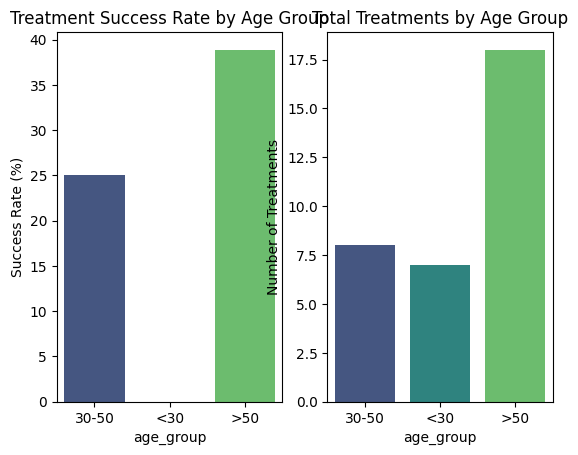

In [35]:
# 8. Visualization
# Create bar plots to visualize treatment success rate and total treatments per age group
plt.subplot(1,2,1)
sns.barplot(
    data=age_group_summary, 
    x="age_group", 
    y="success_rate", 
    hue="age_group",   # x değişkenini hue olarak da atadık
    palette="viridis", 
    dodge=False,       # yan yana çubukları ayırmasın
    legend=False       # legend’i göstermesin
)
plt.title("Treatment Success Rate by Age Group")
plt.ylabel("Success Rate (%)")

# Total treatments plot
plt.subplot(1,2,2)
sns.barplot(
    data=age_group_summary, 
    x="age_group", 
    y="total_treatments", 
    hue="age_group", 
    palette="viridis", 
    dodge=False,
    legend=False
)
plt.title("Total Treatments by Age Group")
plt.ylabel("Number of Treatments")
